In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)   
#GPU内存管理

In [3]:
train_dir = 'sat2/train'
test_dir = 'sat2/val'

im_size = 224
batch_size = 32

In [4]:
train_images = ImageDataGenerator(rescale = 1/255,horizontal_flip=True)
test_images = ImageDataGenerator(rescale = 1/255)
#归一化

In [5]:
train_gen = train_images.flow_from_directory(directory=train_dir,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             target_size=(im_size, im_size),
                                             class_mode='categorical')
#按路径载入图片，批处理大小，随机，尺寸，读热编码

Found 3150 images belonging to 5 classes.


In [6]:
val_gen = test_images.flow_from_directory(directory=test_dir,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          target_size=(im_size, im_size),
                                          class_mode='categorical')
#按路径载入图片，批处理大小，随机，尺寸，读热编码

Found 350 images belonging to 5 classes.


In [7]:
def Inception (ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, input_):
    inputs = tf.keras.layers.Input(shape=input_.shape[1:])
    x1 = tf.keras.layers.Conv2D(ch1x1, kernel_size=1, activation="relu")(inputs)
    
    x21 = tf.keras.layers.Conv2D(ch3x3red, kernel_size=1, activation="relu")(inputs)
    x22 =  tf.keras.layers.Conv2D(ch3x3, kernel_size=3, padding="same", activation="relu")(x21)
    
    x31 = tf.keras.layers.Conv2D(ch5x5red, kernel_size=1, activation="relu")(inputs)
    x32 = tf.keras.layers.Conv2D(ch5x5, kernel_size=5, padding="same", activation="relu")(x31)
    
    x41 = tf.keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same")(inputs) 
    x42 = tf.keras.layers.Conv2D(pool_proj, kernel_size=1, activation="relu")(x41)
    outputs = tf.concat((x1, x22, x32, x42),axis=-1)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
def InceptionAux (num_classes, input_):
    inputs = tf.keras.layers.Input(shape=input_.shape[1:])
    x = tf.keras.layers.AvgPool2D(pool_size=5, strides=3)(inputs)
    x = tf.keras.layers.Conv2D(128, kernel_size=1, activation="relu")(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.7)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(rate=0.7)(x)
    x = tf.keras.layers.Dense(num_classes)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [9]:
def GoogLeNet():
    input_image = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same", activation="relu")(input_image)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Conv2D(192, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    
    #3a
    x = Inception(64, 96, 128, 16, 32, 32, x)(x)
    #3b
    x = Inception(128, 128, 192, 32, 96, 64, x)(x)

    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    #4a
    x = Inception(192, 96, 208, 16, 48, 64, x)(x)
    #aux1
    aux11 = InceptionAux(5,x)(x)
    aux1 = tf.keras.layers.Softmax(name="aux_1")(aux11)
    #4b
    x = Inception(160, 112, 224, 24, 64, 64, x)(x)
    #4c
    x = Inception(128, 128, 256, 24, 64, 64, x)(x)
    #4d
    x = Inception(112, 144, 288, 32, 64, 64, x)(x)
    #aux2
    aux22 = InceptionAux(5,x)(x)
    aux2 = tf.keras.layers.Softmax(name="aux_2")(aux22)
    #4e
    x = Inception(256, 160, 320, 32, 128, 128, x)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    #5a
    x = Inception(256, 160, 320, 32, 128, 128, x)(x)
    #5b
    x = Inception(384, 192, 384, 48, 128, 128, x)(x)
    x = tf.keras.layers.AvgPool2D(pool_size=7, strides=1)(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dropout(rate=0.4)(x)
    x = tf.keras.layers.Dense(5)(x)
    #aux3
    aux3 = tf.keras.layers.Softmax(name="aux_3")(x)

    model = tf.keras.models.Model(inputs=input_image, outputs=[aux1, aux2, aux3])
#     model = tf.keras.models.Model(inputs=input_image, outputs=aux3)
    return model

In [10]:
model = GoogLeNet()

In [11]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d[0][0]              
___________________________________________________________________________________________

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['acc'])
#学习率设置

In [13]:
history = model.fit(train_gen,epochs=20,validation_data=val_gen)

Epoch 1/20
99/99 [==============================] - 12s 70ms/step - loss: 4.7388 - aux_1_loss: 1.5717 - aux_2_loss: 1.5815 - aux_3_loss: 1.5857 - aux_1_acc: 0.2274 - aux_2_acc: 0.2195 - aux_3_acc: 0.2041 - val_loss: 3.7580 - val_aux_1_loss: 1.2492 - val_aux_2_loss: 1.2531 - val_aux_3_loss: 1.2557 - val_aux_1_acc: 0.4657 - val_aux_2_acc: 0.4457 - val_aux_3_acc: 0.4229
Epoch 2/20
99/99 [==============================] - 5s 51ms/step - loss: 3.8507 - aux_1_loss: 1.2815 - aux_2_loss: 1.2896 - aux_3_loss: 1.2796 - aux_1_acc: 0.3853 - aux_2_acc: 0.3747 - aux_3_acc: 0.3706 - val_loss: 3.7841 - val_aux_1_loss: 1.2400 - val_aux_2_loss: 1.2657 - val_aux_3_loss: 1.2784 - val_aux_1_acc: 0.4257 - val_aux_2_acc: 0.4086 - val_aux_3_acc: 0.3886
Epoch 3/20
99/99 [==============================] - 5s 51ms/step - loss: 3.7424 - aux_1_loss: 1.2328 - aux_2_loss: 1.2562 - aux_3_loss: 1.2534 - aux_1_acc: 0.4059 - aux_2_acc: 0.3904 - aux_3_acc: 0.3893 - val_loss: 3.7003 - val_aux_1_loss: 1.2147 - val_aux_2_lo

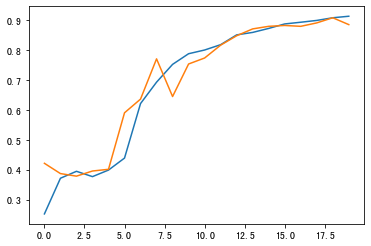

In [14]:
plt.plot(history.epoch,history.history.get('aux_3_acc'))
plt.plot(history.epoch,history.history.get('val_aux_3_acc'))

In [15]:
model.evaluate(val_gen)

11/11 [==============================] - 0s 41ms/step - loss: 1.0314 - aux_1_loss: 0.3490 - aux_2_loss: 0.3243 - aux_3_loss: 0.3581 - aux_1_acc: 0.8971 - aux_2_acc: 0.9000 - aux_3_acc: 0.8857


[1.0314477682113647,
 0.34904995560646057,
 0.32426247000694275,
 0.35813525319099426,
 0.8971428275108337,
 0.8999999761581421,
 0.8857142925262451]

In [16]:
# 保存模型
model.save('sat75.h5')